In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
#from multiclass_classification import colors, plot_from_samples
from tensorflow_probability import distributions as tfd 
import gpflow
from torch.utils.data import  TensorDataset
import torch
from gpflow import set_trainable
from gpflow.ci_utils import reduce_in_tests
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float
tf.random.set_seed(123)

2023-11-30 21:20:05.533478: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def create_dataset(dataset, static, pca, fold):
    dataset_path = ('./data/' + dataset + '.pth')
    dataset = TensorDataset(*torch.load(dataset_path))
    X, Y = dataset.tensors
    X, Y = X.numpy().astype(np.float64), Y.numpy().astype(np.float64)
    if not static:
        Y_mean, Y_std = Y.mean(0), Y.std(0) + 1e-9
        return X, Y, Y_mean, Y_std
    else:
        X_train_indices_boolean = np.random.choice([1, 0], size=X.shape[0], p=[0.8, 0.2])
        X_train_indices = np.where(X_train_indices_boolean == 1)[0]
        X_test_indices = np.where(X_train_indices_boolean == 0)[0]
        X_train = X[X_train_indices]
        Y_train = Y[X_train_indices]
        X_test = X[X_test_indices]
        Y_test = Y[X_test_indices]
        Pd = None
        Y_train_mean, Y_train_std = Y_train.mean(0), Y_train.std(0) + 1e-9
        Y_train = (Y_train - Y_train_mean) / Y_train_std
        Y_test = (Y_test - Y_train_mean) / Y_train_std
        return X_train, Y_train, X_test, Y_test, Y_train_mean, Y_train_std, X_train_indices, X_test_indices, Pd

In [3]:
dataset = 'boston'
X_train, Y_train,  X_test, Y_test, Y_train_mean, Y_train_std, X_train_indices, X_test_indices, Pd = create_dataset(dataset, True, -1, 0)
data = (X_train, Y_train)
D_in = X_train.shape[1]

In [4]:
kernel = gpflow.kernels.SquaredExponential(variance=0.1, lengthscales=np.ones(D_in)**0.5)
model = gpflow.models.GPR(data, kernel=kernel)
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.1
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(13,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


In [5]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, model.trainable_variables)

print(f"log posterior density at optimum: {model.log_posterior_density()}")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
log posterior density at optimum: -110.72820569583325


In [14]:
# tfp.distributions dtype is inferred from parameters - so convert to 64-bit
model.kernel.lengthscales.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.likelihood.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))

gpflow.utilities.print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,1.62975
GPR.kernel.lengthscales,Parameter,Softplus,Gamma,True,"(13,)",float64,"[2.93907, 8.07836, 11.24729..."
GPR.likelihood.variance,Parameter,Softplus + Shift,Gamma,True,(),float64,0.03384


In [22]:
model.log_posterior_density

<bound method BayesianModel.log_posterior_density of <gpflow.models.gpr.GPR object at 0x7fa2e701ac70>>

In [15]:
num_burnin_steps = reduce_in_tests(300)
num_samples = reduce_in_tests(1000)

# Note that here we need model.trainable_parameters, not trainable_variables - only parameters can have priors!
hmc_helper = gpflow.optimizers.SamplingHelper(
    model.log_posterior_density, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn,
    num_leapfrog_steps=10,
    step_size=0.01,
)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc,
    num_adaptation_steps=10,
    target_accept_prob=f64(0.75),
    adaptation_rate=0.1,
)

@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )


samples, traces = run_chain_fn()
parameter_samples = hmc_helper.convert_to_constrained_values(samples)

param_to_name = {
    param: name
    for name, param in gpflow.utilities.parameter_dict(model).items()
}

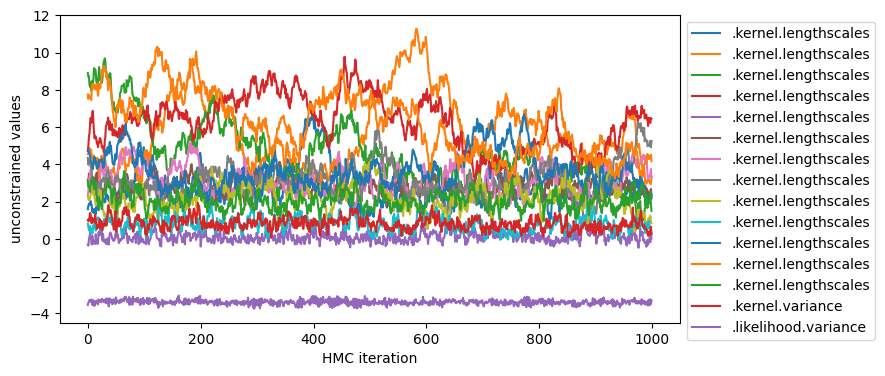

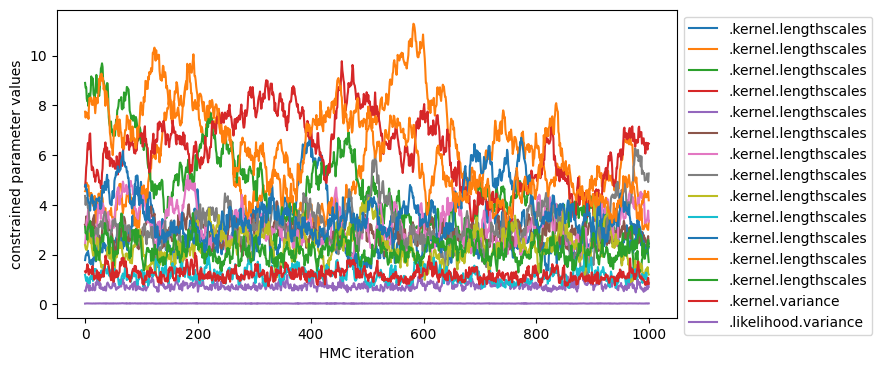

In [16]:
def plot_samples(samples, parameters, y_axis_label):
    plt.figure(figsize=(8, 4))
    for val, param in zip(samples, parameters):
        plt.plot(tf.squeeze(val), label=param_to_name[param])
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.xlabel("HMC iteration")
    plt.ylabel(y_axis_label)


plot_samples(samples, model.trainable_parameters, "unconstrained values")
plot_samples(
    parameter_samples,
    model.trainable_parameters,
    "constrained parameter values",
)

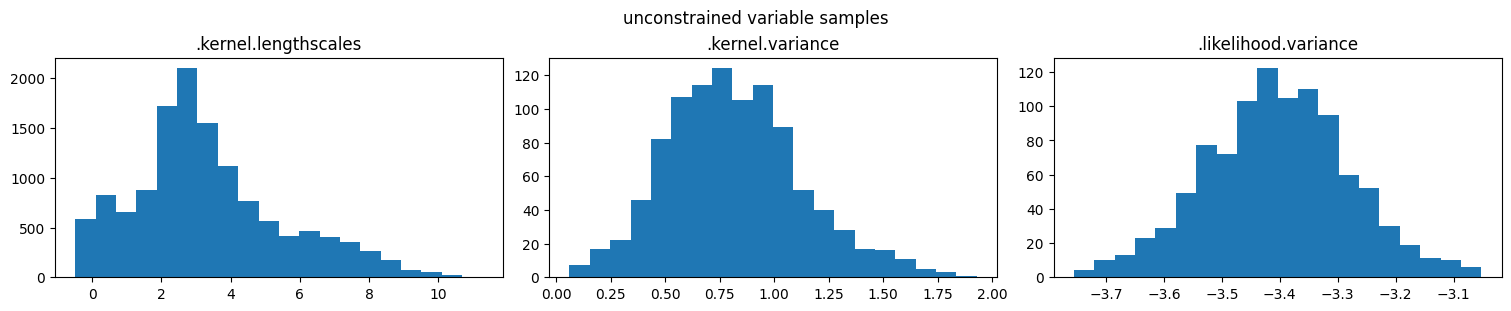

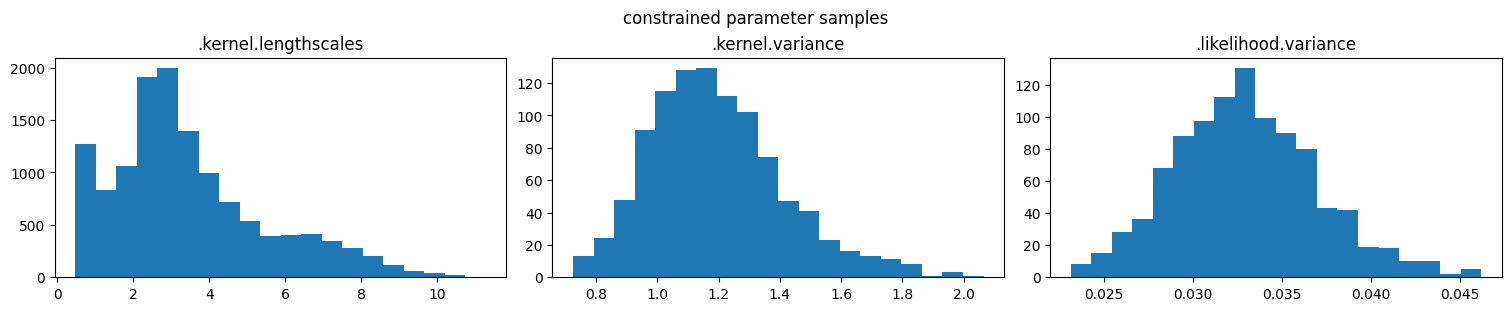

In [17]:
def marginal_samples(samples, parameters, y_axis_label):
    fig, axes = plt.subplots(
        1, len(param_to_name), figsize=(15, 3), constrained_layout=True
    )
    for ax, val, param in zip(axes, samples, parameters):
        ax.hist(np.stack(val).flatten(), bins=20)
        ax.set_title(param_to_name[param])
    fig.suptitle(y_axis_label)
    plt.show()


marginal_samples(
    samples, model.trainable_parameters, "unconstrained variable samples"
)
marginal_samples(
    parameter_samples,
    model.trainable_parameters,
    "constrained parameter samples",
)